In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

import matplotlib.lines as mlines
import seaborn
matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)
matplotlib.rcParams['font.size'] = 7
seaborn.set_style('darkgrid')

from braindecode.scripts.print_results import ResultPrinter
from braindecode.csp.print_results import CSPResultPrinter
import logging
log = logging.getLogger()
log.setLevel("DEBUG")
from braindecode.scripts.train_experiments import setup_logging
setup_logging()

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled, cuDNN 5005)
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from braindecode.experiments.load import load_exp_and_model
from braindecode.veganlasagne.layer_util import print_layers, recompute_bnorm_layer_statistics
import lasagne

In [3]:
exp, model = load_exp_and_model('../data/models/paper/ours/cnt/deep4/243', set_invalid_to_NaN=False)
%cd ../

2016-11-24 13:23:52,589 Setting n_sample preds automatically to 479
2016-11-24 13:23:52,591 Input window length is 522
2016-11-24 13:23:52,678 Setting n_sample preds automatically to 479
2016-11-24 13:23:52,679 Input window length is 522
/home/hartmank/braindecode


"Conv2DAllColsLayer" is just a normal conv2d-layer which dynamically is assigned the filter size of 1x(4th input dim).
Should be replacable by normal Conv2DLayer if needed.

In [4]:
from braindecode.veganlasagne.layers import FinalReshapeLayer
print model
all_l = lasagne.layers.get_all_layers(model)
model = all_l[-3]
model = FinalReshapeLayer(model,remove_invalids=True,flatten=False)
model = lasagne.layers.DimshuffleLayer(model,(0,2,1,3))
model = lasagne.layers.ReshapeLayer(model,(-1,4))
model = lasagne.layers.NonlinearityLayer(model,nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
print_layers(model)

 0-InputLayer                                                         [None, 44, 1000, 1]
 1-DimshuffleLayer                                                    (None, 1, 1000, 44)
 2-DropoutLayer             0.000                                    
 3-Conv2DLayer              10x1                                      (None, 25, 991, 44)
 4-Conv2DAllColsLayer       1x44                                      (None, 25, 991, 1)
 5-BatchNormLayer                                     elu            
 6-Pool2DLayer              3x1                       max             (None, 25, 989, 1)
 7-StrideReshapeLayer           ::3 ::1                               (None, 25, 330, 1)
 8-NonlinearityLayer                                                 
 9-DropoutLayer             0.500                                    
10-Conv2DLayer              10x1                                      (None, 50, 321, 1)
11-BatchNormLayer                                     elu            
12-Pool2DLayer          

### Load and get data

In [6]:
exp.dataset.load()

2016-11-24 13:23:59,342 Load Training Set...
2016-11-24 13:24:21,627 Load Test Set...
2016-11-24 13:24:26,471 Clean Training Set...
2016-11-24 13:24:27,095 Rejected channels: []
2016-11-24 13:24:27,096 #Clean trials:     895
2016-11-24 13:24:27,096 #Rejected trials:  2
2016-11-24 13:24:27,097 Fraction Clean:    99.0%
2016-11-24 13:24:27,097 (from maxmin):     2
2016-11-24 13:24:27,097 (from var):        0
2016-11-24 13:24:27,269 Clean Test Set...
2016-11-24 13:24:27,378 Rejected channels: []
2016-11-24 13:24:27,379 #Clean trials:     160
2016-11-24 13:24:27,379 #Rejected trials:  0
2016-11-24 13:24:27,380 Fraction Clean:    100.0%
2016-11-24 13:24:27,380 (from maxmin):     0
2016-11-24 13:24:27,380 (from var):        0
2016-11-24 13:24:27,381 Create Cleaned Cnt Sets...
2016-11-24 13:24:28,505 Create sets from cleaned cnt...
2016-11-24 13:24:28,506 Preprocess continuous signal...
2016-11-24 13:24:48,127 Not doing any bandpass, since low 0 or None and high None
2016-11-24 13:25:02,148 Lo

In [7]:
datasets = exp.dataset_provider.get_train_merged_valid_test(exp.dataset)

In [8]:
test_batches = list(exp.iterator.get_batches(datasets['test'], shuffle=False))

### Just for showing how to make some predictions

In [9]:
from braindecode.veganlasagne.layers import create_pred_fn
pred_fn = create_pred_fn(model)

/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [10]:
inputs, targets = test_batches[0]
inputs = np.expand_dims(inputs[0,:],axis=0)
print inputs.shape
pred = pred_fn(inputs)
print pred.shape

print targets.shape

(1, 44, 1000, 1)
(479, 4)
(28740, 4)


In [11]:
all_preds = []
all_targets = []
for inputs, targets in test_batches:
    all_preds.append(pred_fn(inputs))
    all_targets.append(targets)
all_targets = np.concatenate(all_targets)
all_preds = np.concatenate(all_preds)

In [12]:
print("Accuracy: {:.2f}%".format(100 * 
    np.mean(np.argmax(all_targets, axis=1) == np.argmax(all_preds, axis=1))))

Accuracy: 98.53%


In [21]:
%cd '/home/hartmank/braindecode/convvisual'
from convvisual import *

layer = 29
filter = 0
inputs, targets = test_batches[0]

RF_model,layer = check_if_finalreshape_is_needed(model,layer)
all_l = lasagne.layers.get_all_layers(RF_model)
print_layers(RF_model)
#Get highest input/unit activation combination
max_ind = get_most_active_units_in_layer(inputs,RF_model,layer,n_units=10,filter=filter)
print max_ind.shape

/home/hartmank/braindecode/convvisual
 0-InputLayer                                                         [None, 44, 1000, 1]
 1-DimshuffleLayer                                                    (None, 1, 1000, 44)
 2-DropoutLayer             0.000                                    
 3-Conv2DLayer              10x1                                      (None, 25, 991, 44)
 4-Conv2DAllColsLayer       1x44                                      (None, 25, 991, 1)
 5-BatchNormLayer                                     elu            
 6-Pool2DLayer              3x1                       max             (None, 25, 989, 1)
 7-StrideReshapeLayer           ::3 ::1                               (None, 25, 330, 1)
 8-NonlinearityLayer                                                 
 9-DropoutLayer             0.500                                    
10-Conv2DLayer              10x1                                      (None, 50, 321, 1)
11-BatchNormLayer                                     el

In [24]:
print_layers(RF_model)
l_RF = receptive_field_build_deconv_layers(RF_model[layer],RF_model[1],use_learned_W=False,X_reshape=81)

print_layers(l_RF)
RF_output = get_receptive_field_mask(max_ind,l_RF)


X_RF = get_receptive_field_masked_inputs(inputs,max_ind,l_RF)


 0-InputLayer                                                         [None, 44, 1000, 1]
 1-DimshuffleLayer                                                    (None, 1, 1000, 44)
 2-DropoutLayer             0.000                                    
 3-Conv2DLayer              10x1                                      (None, 25, 991, 44)
 4-Conv2DAllColsLayer       1x44                                      (None, 25, 991, 1)
 5-BatchNormLayer                                     elu            
 6-Pool2DLayer              3x1                       max             (None, 25, 989, 1)
 7-StrideReshapeLayer           ::3 ::1                               (None, 25, 330, 1)
 8-NonlinearityLayer                                                 
 9-DropoutLayer             0.500                                    
10-Conv2DLayer              10x1                                      (None, 50, 321, 1)
11-BatchNormLayer                                     elu            
12-Pool2DLayer          

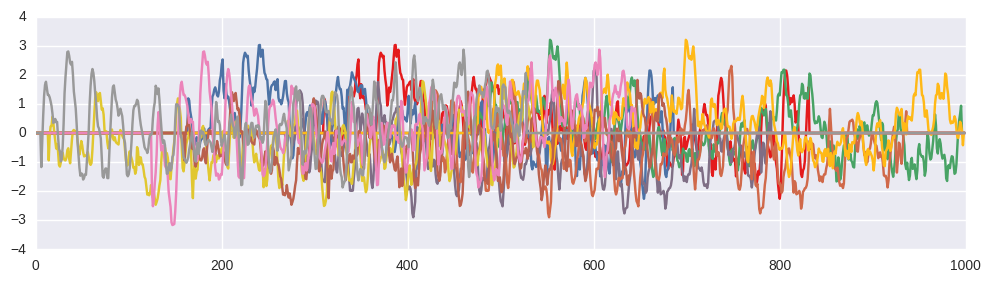

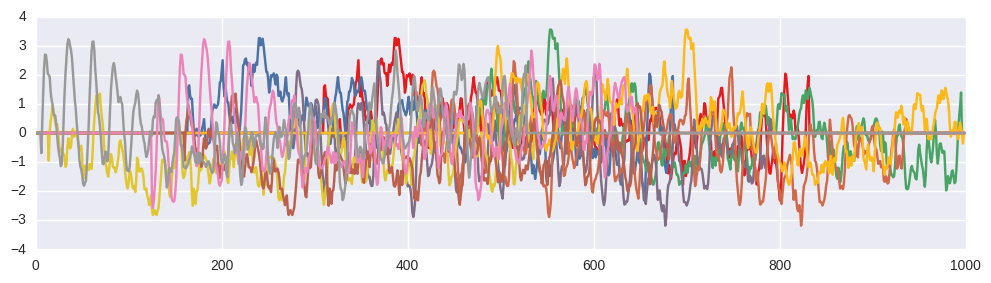

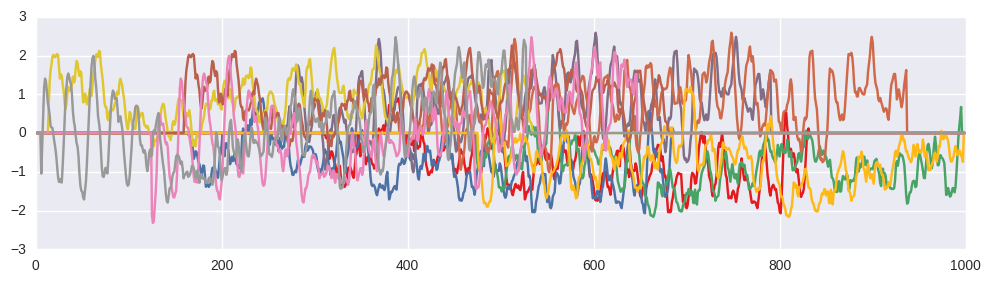

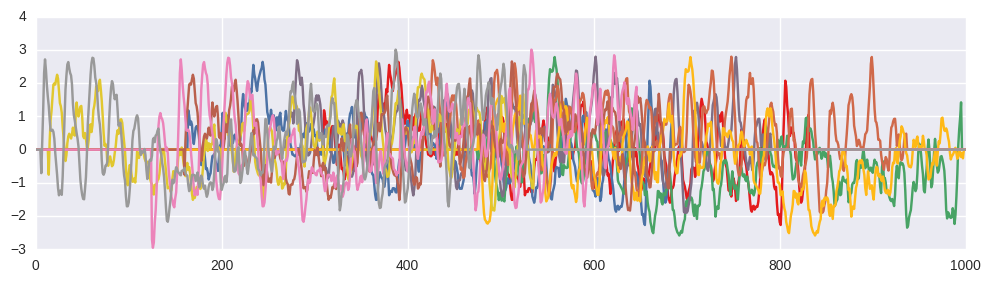

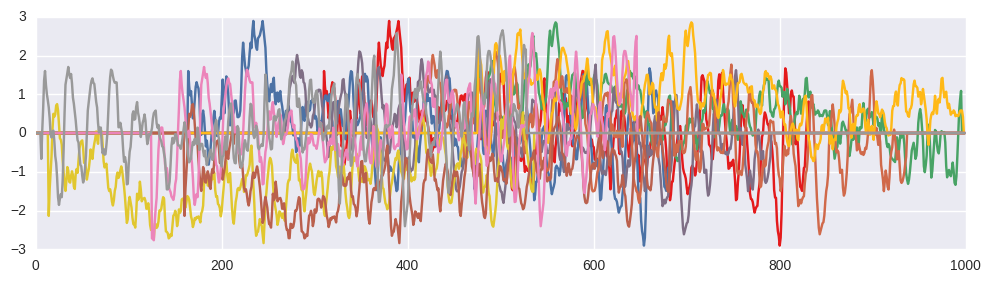

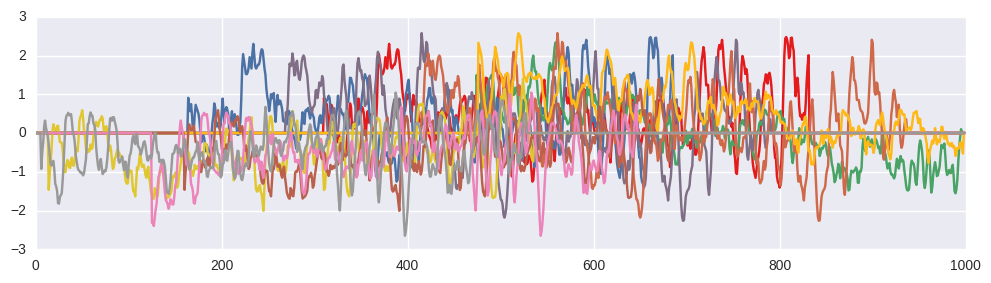

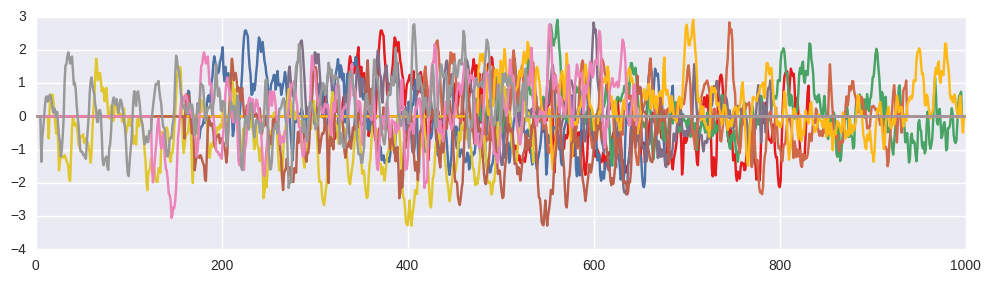

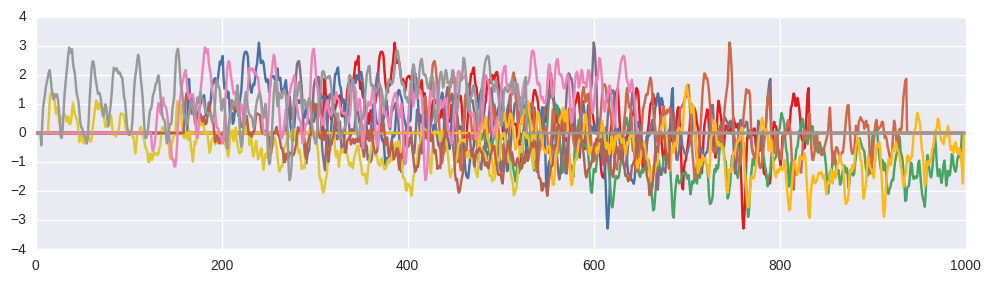

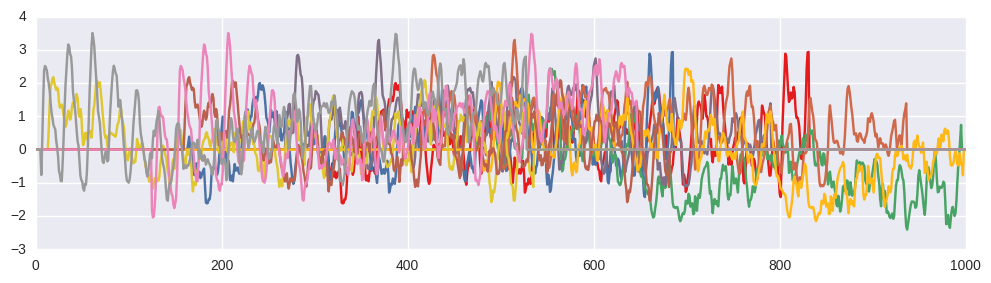

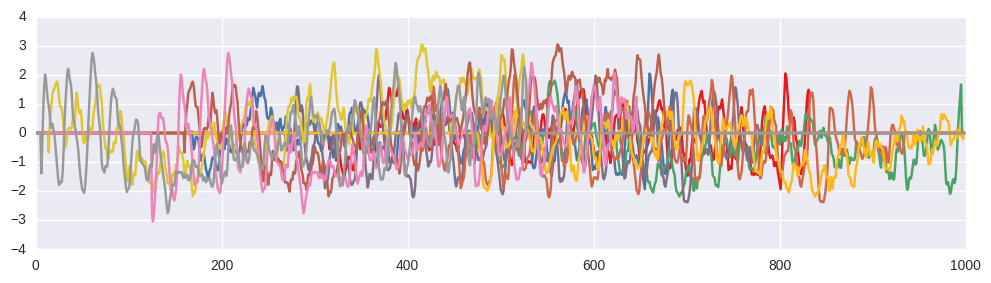

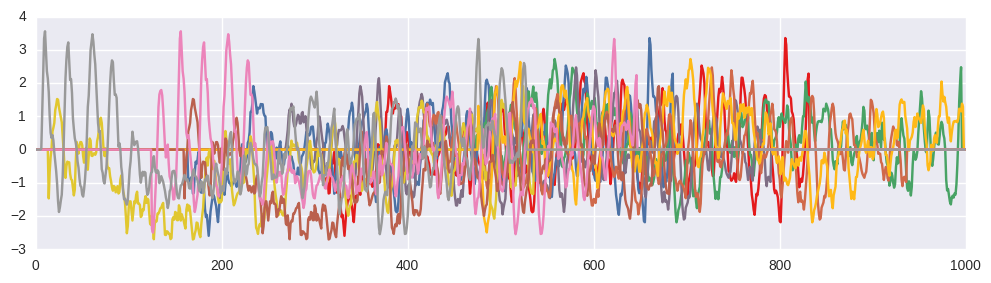

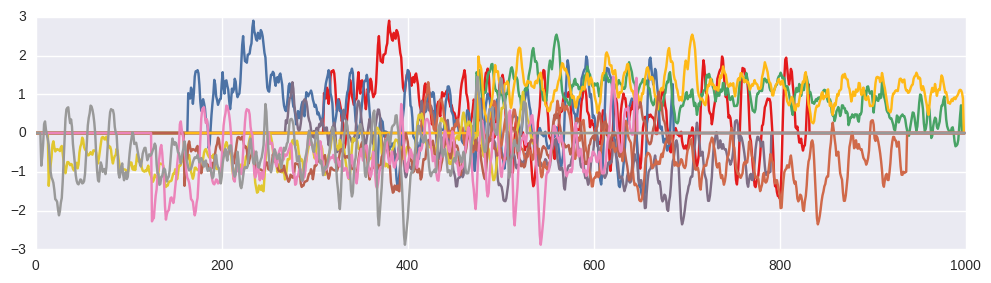

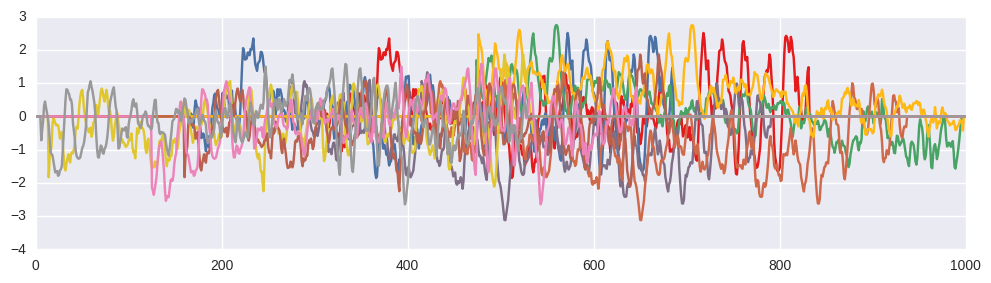

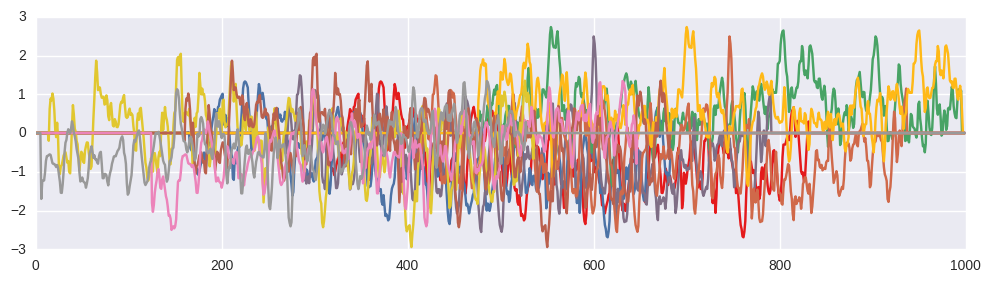

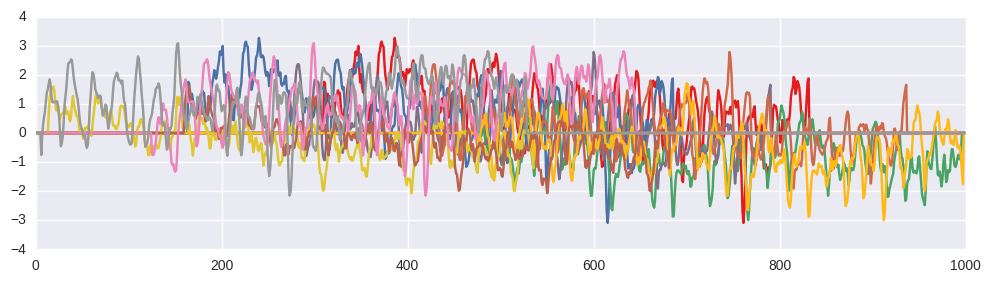

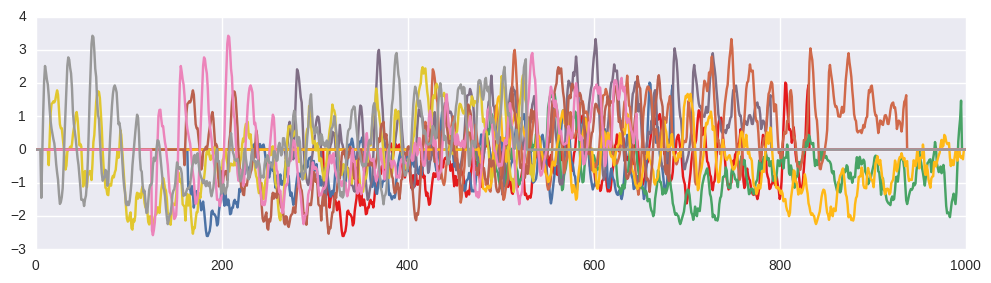

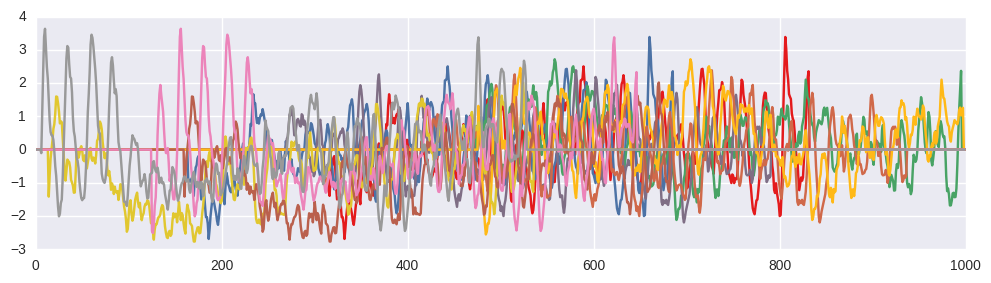

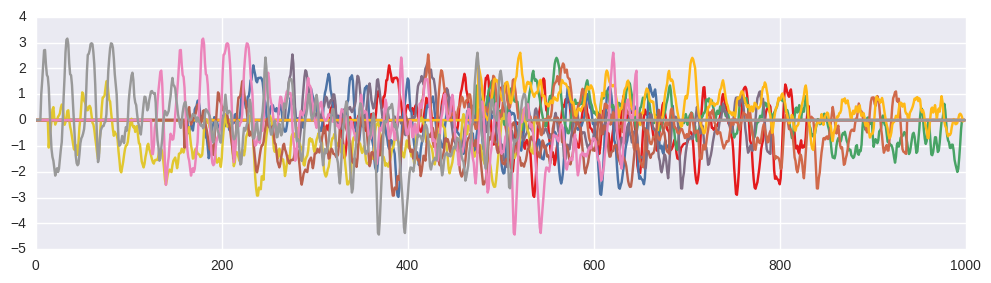

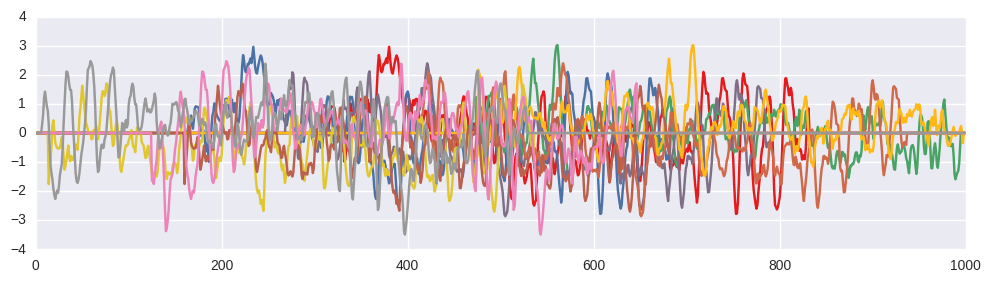

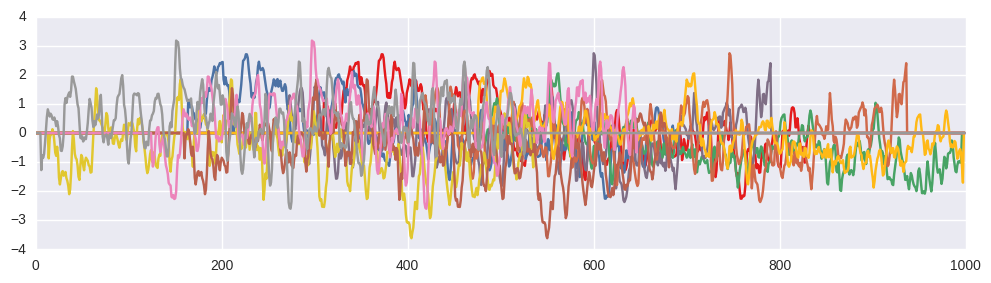

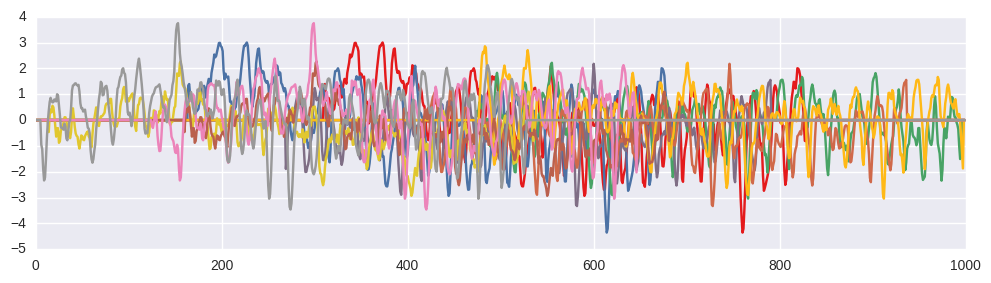

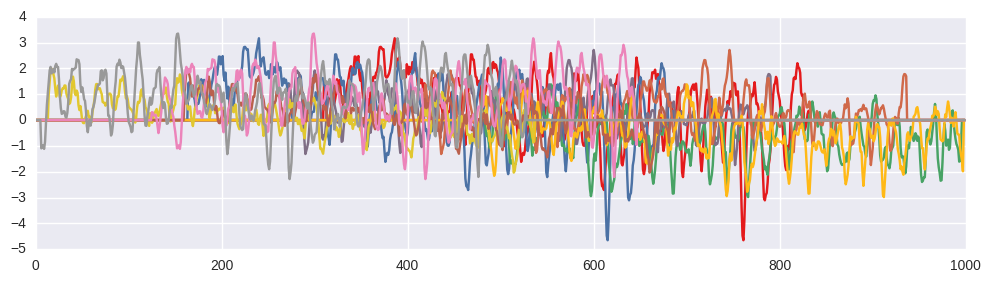

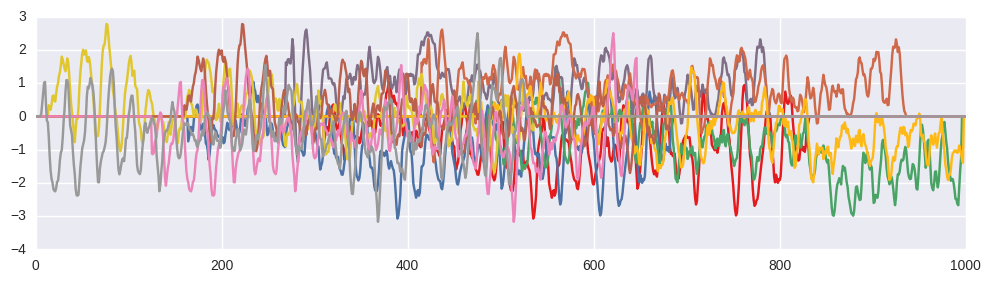

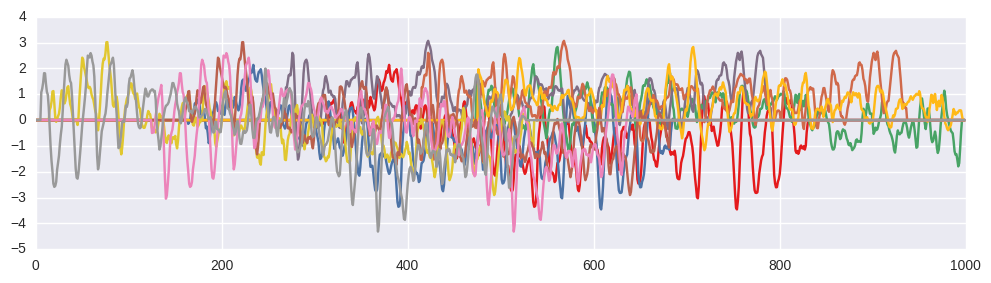

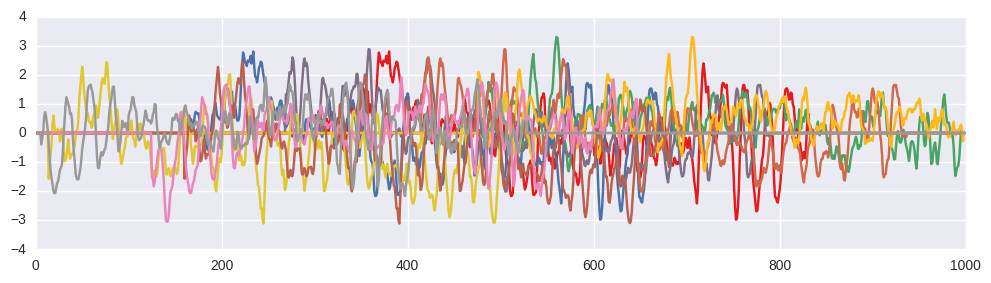

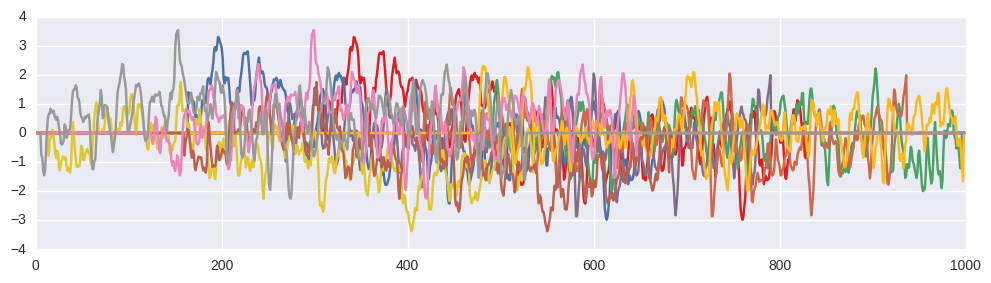

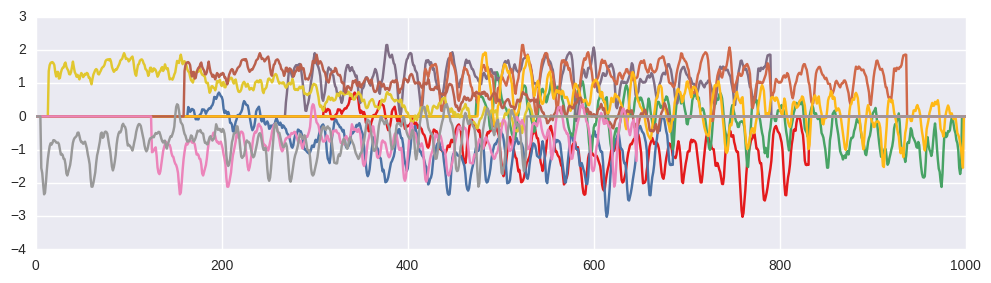

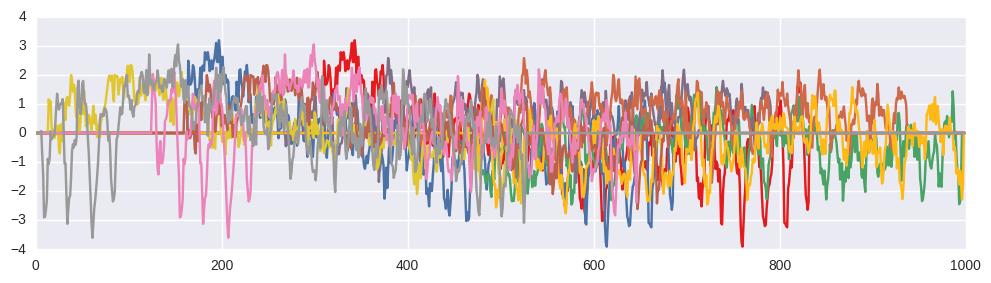

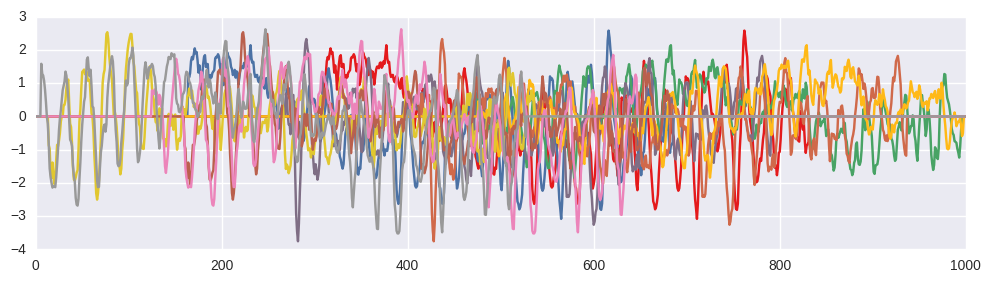

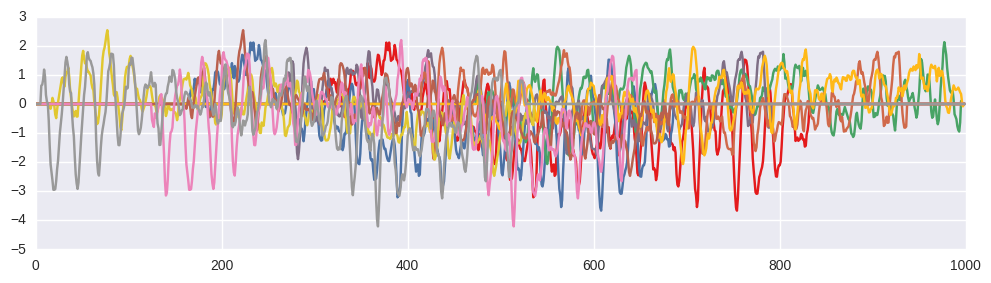

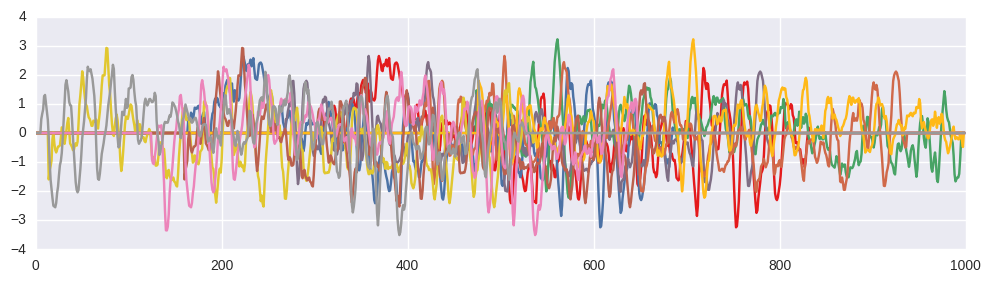

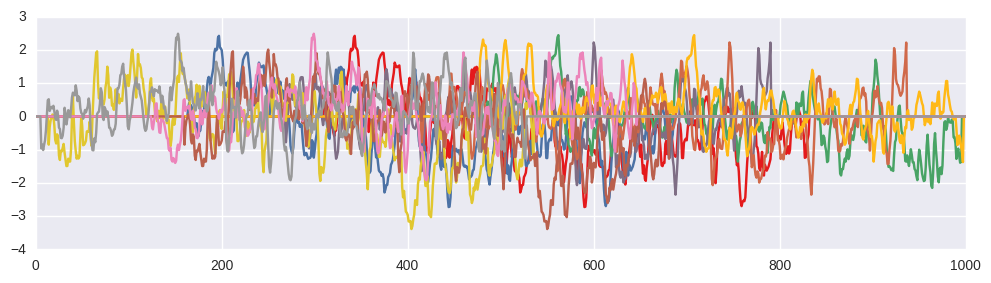

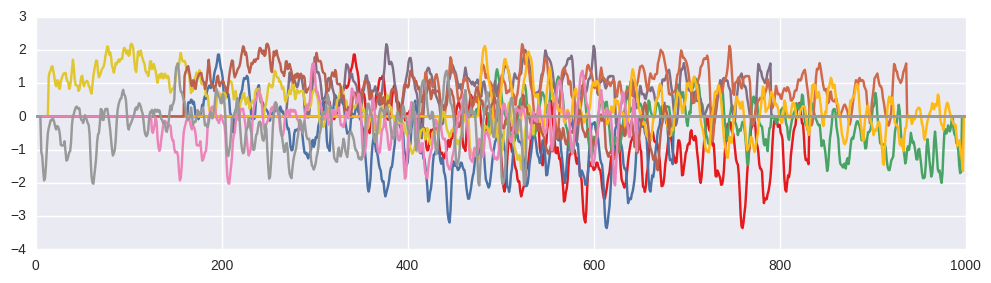

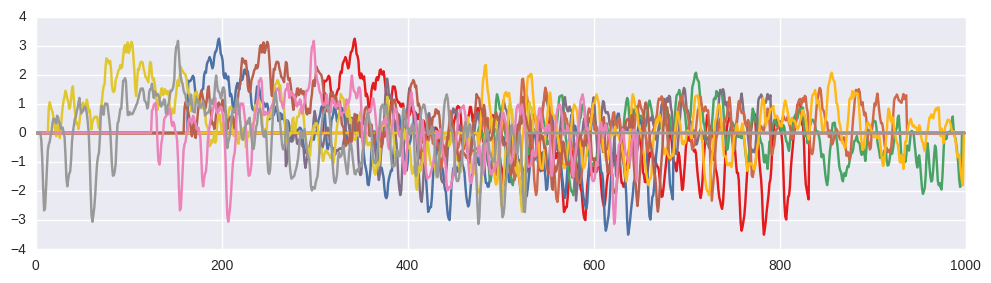

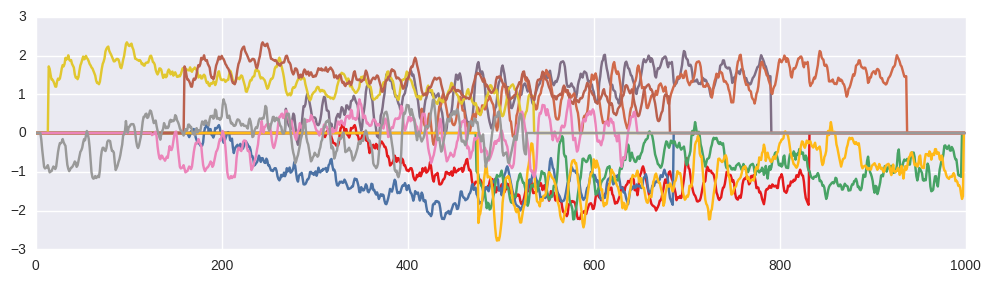

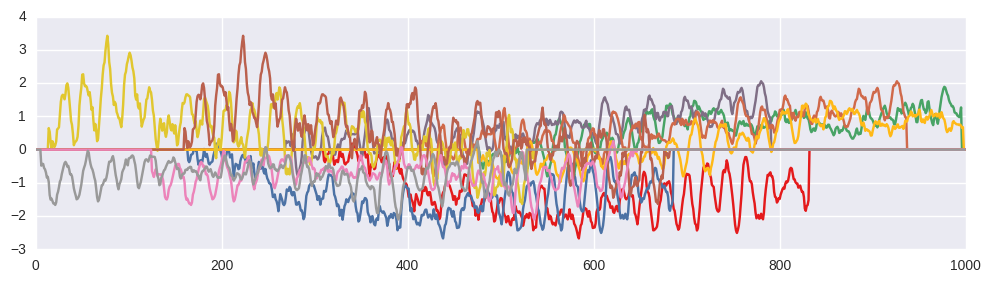

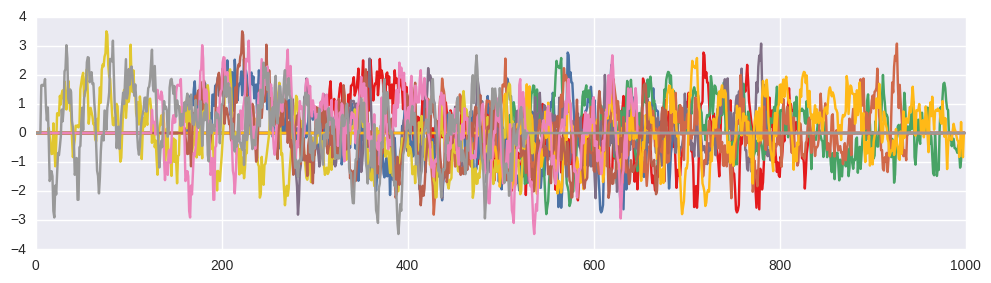

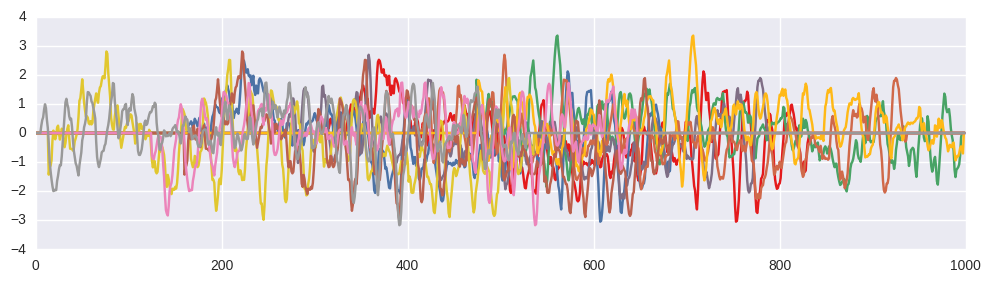

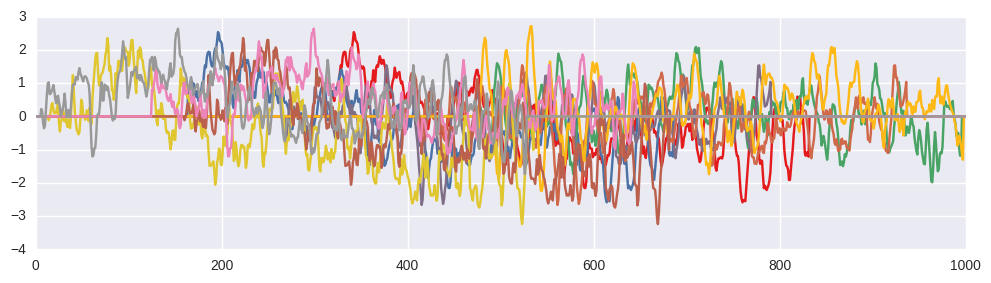

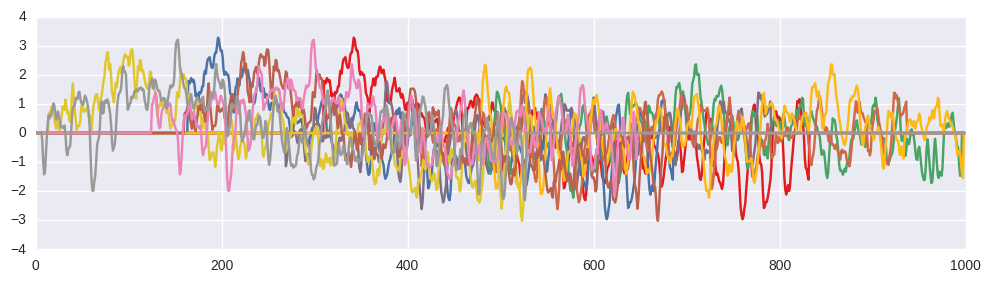

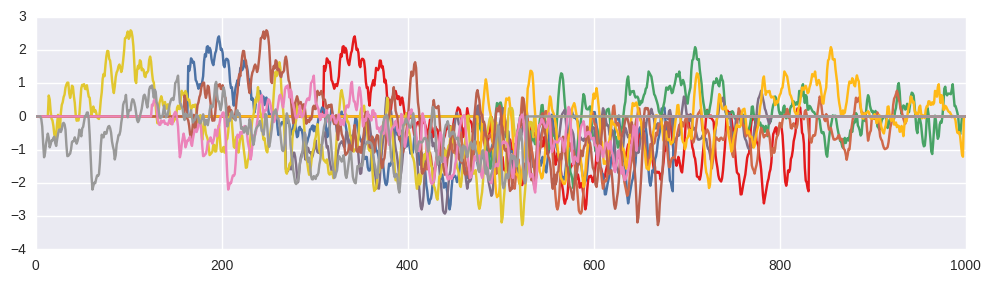

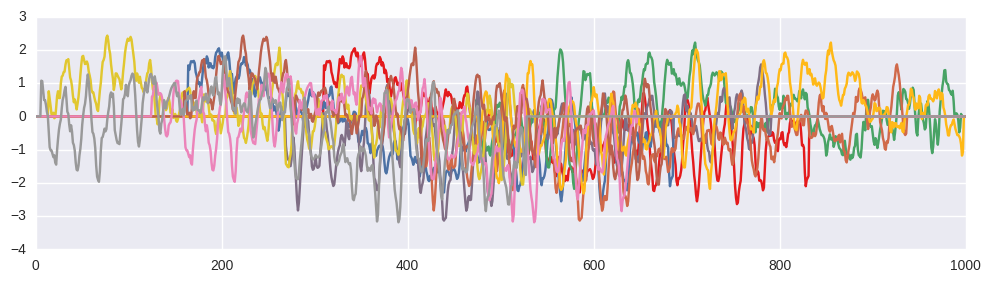

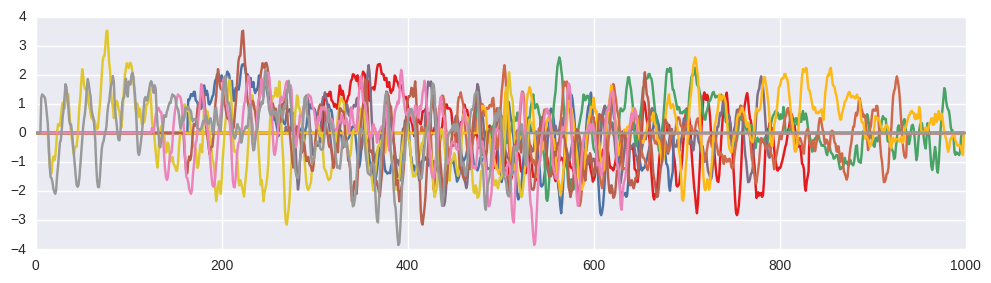

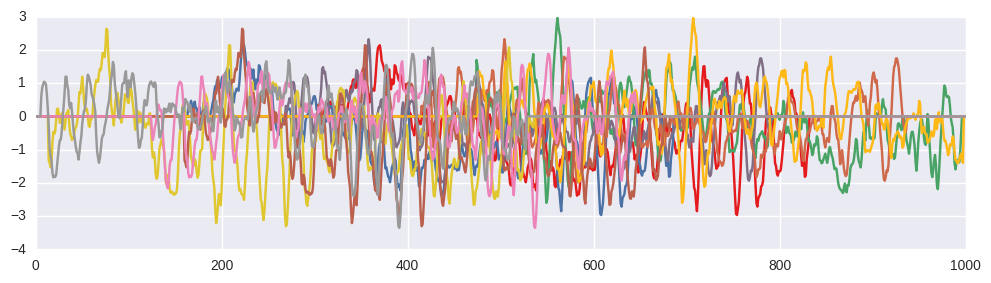

In [44]:
from cycler import cycler
color=cm.get_cmap('Set1')(np.linspace(0,1,X_RF.shape[0]))
for i in np.arange(X_RF.shape[1]):
    plt.gca().set_prop_cycle(cycler('color',color))
    plt.plot(X_RF[:,i,:,:].squeeze().T)
    plt.show()

In [14]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
